In [1]:
# check gpu status
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9184023022382624439
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9868148736
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7697980164289318950
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


## Loading the data

In [1]:
# Import modules
from __future__ import print_function
import numpy as np
import pickle
from tqdm import tqdm
import cv2
import os
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras import Model
from tensorflow.keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.initializers import GlorotNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
train_dir = "C:/Users/Owner/Downloads/tiny-imagenet-200/tiny-imagenet-200/train"

x_train = []
y_train = []
for class_idx, classes in enumerate(os.listdir(train_dir)):
    if classes.endswith(".DS_Store"):
        continue
    print(f"Processing class {class_idx + 1}/{len(os.listdir(train_dir))}: {classes}")
    
    # Iterate over images
    for image_idx, images in enumerate(os.listdir(os.path.join(train_dir, classes, "images"))):
        image = cv2.imread(os.path.join(train_dir, classes, "images", images))
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_array = img_to_array(img) / 255.0
        x_train.append(img_array)
        y_train.append(classes)

print("Dataset loading completed.")

Processing class 1/200: n01443537
Processing class 2/200: n01629819
Processing class 3/200: n01641577
Processing class 4/200: n01644900
Processing class 5/200: n01698640
Processing class 6/200: n01742172
Processing class 7/200: n01768244
Processing class 8/200: n01770393
Processing class 9/200: n01774384
Processing class 10/200: n01774750
Processing class 11/200: n01784675
Processing class 12/200: n01855672
Processing class 13/200: n01882714
Processing class 14/200: n01910747
Processing class 15/200: n01917289
Processing class 16/200: n01944390
Processing class 17/200: n01945685
Processing class 18/200: n01950731
Processing class 19/200: n01983481
Processing class 20/200: n01984695
Processing class 21/200: n02002724
Processing class 22/200: n02056570
Processing class 23/200: n02058221
Processing class 24/200: n02074367
Processing class 25/200: n02085620
Processing class 26/200: n02094433
Processing class 27/200: n02099601
Processing class 28/200: n02099712
Processing class 29/200: n021

In [8]:
my_dict = {}
f = "C:/Users/Owner/Downloads/tiny-imagenet-200/tiny-imagenet-200/val/val_annotations.txt"
with open(f, 'r', newline='', encoding='utf-8') as tsvfile:
    # Create a CSV reader with tab as the delimiter
    reader = csv.reader(tsvfile, delimiter='\t')
    # Iterate through the rows in the TSV file
    for row in reader:
        # Each row is a list of values corresponding to columns
        my_dict[row[0]] = row[1]

val_dir = "C:/Users/Owner/Downloads/tiny-imagenet-200/tiny-imagenet-200/val/images"

x_val = []
y_val =[]

for images in os.listdir(val_dir):
    image = cv2.imread(os.path.join(val_dir,images))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_array = img_to_array(img) / 255.0
    x_val.append(img_array)
    y_val.append(my_dict[images])  

In [9]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [10]:
label_encoder = LabelEncoder()

label_encoder.fit(y_train)
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [ ]:
# Save the training data with pickle for faster loading

save_dir = "C:/Users/Owner/Downloads/4040Project-main/4040Project-main/"

with open(os.path.join(save_dir, 'x_train.pkl'), 'wb') as file:
    pickle.dump(x_train, file)

with open(os.path.join(save_dir, 'y_train.pkl'), 'wb') as file:
    pickle.dump(y_train, file)

with open(os.path.join(save_dir, 'x_val.pkl'), 'wb') as file:
    pickle.dump(x_val, file)

with open(os.path.join(save_dir, 'y_val.pkl'), 'wb') as file:
    pickle.dump(y_val, file)

In [2]:
# loading data with pickle

load_dir = "C:/Users/Owner/Downloads/4040Project-main/4040Project-main/"

with open(os.path.join(load_dir, 'x_train.pkl'), 'rb') as file:
    x_train = pickle.load(file)

with open(os.path.join(load_dir, 'y_train.pkl'), 'rb') as file:
    y_train = pickle.load(file)

with open(os.path.join(load_dir, 'x_val.pkl'), 'rb') as file:
    x_val = pickle.load(file)

with open(os.path.join(load_dir, 'y_val.pkl'), 'rb') as file:
    y_val = pickle.load(file)

In [3]:
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_val.shape)
print('Test labels shape: ', y_val.shape)

Training data shape:  (100000, 64, 64, 3)
Training labels shape:  (100000,)
Test data shape:  (10000, 64, 64, 3)
Test labels shape:  (10000,)


In [4]:
# Training conditions
intializer = GlorotNormal(seed=None)
def scheduler(epoch, lr):
    if epoch != 30 or epoch != 30 or epoch != 90:
        return lr
    else:
        return lr/10
    
callback = LearningRateScheduler(scheduler)

In [5]:
batch_size = 32

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size, shuffle=False)

## 1:  Comparison of error curves

### 1: Batch Normalization

In [41]:
# Simpliyied ResNet model that works better with the Tiny_ImageNet-200 dataset, using this model

model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 29, 29, 64)        9472      
                                                                 
 batch_normalization_6 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_27 (Activation)  (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 15, 15, 256)       16640     
                                                                 
 batch_normalization_7 (Batc  (None, 15, 15, 256)    

c:\Users\Owner\anaconda3\envs\gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [42]:
batch_size = 32
epochs = 100


hist1 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/100
3125/3125 [==============================] - 9s 3ms/step - loss: 4.8685 - accuracy: 0.0353 - val_loss: 4.6247 - val_accuracy: 0.0595 - lr: 0.0010
Epoch 2/100
3125/3125 [==============================] - 8s 3ms/step - loss: 4.4903 - accuracy: 0.0708 - val_loss: 4.3980 - val_accuracy: 0.0828 - lr: 0.0010
Epoch 3/100
3125/3125 [==============================] - 9s 3ms/step - loss: 4.3610 - accuracy: 0.0852 - val_loss: 4.1217 - val_accuracy: 0.1184 - lr: 0.0010
Epoch 4/100
3125/3125 [==============================] - 9s 3ms/step - loss: 4.2877 - accuracy: 0.0930 - val_loss: 4.2630 - val_accuracy: 0.1056 - lr: 0.0010
Epoch 5/100
3125/3125 [==============================] - 9s 3ms/step - loss: 4.2359 - accuracy: 0.1019 - val_loss: 4.1097 - val_accuracy: 0.1216 - lr: 0.0010
Epoch 6/100
3125/3125 [==============================] - 9s 3ms/step - loss: 4.1922 - accuracy: 0.1072 - val_loss: 4.2945 - val_accuracy: 0.1039 - lr: 0.0010
Epoch 7/100
3125/3125 [=============================

In [43]:
# Save hist1

with open('hist1.pkl', 'wb') as file:
    pickle.dump(hist1.history, file)

In [17]:
# Load hist1

with open(os.path.join(load_dir, 'hist1.pkl'), 'rb') as file:
    hist1 = pickle.load(file)

### 2: Group Normalization

In [7]:
from GroupNormalization import GroupNormalization

In [8]:
model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
model.add(GroupNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
model.add(GroupNormalization())
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 64)        9472      
                                                                 
 group_normalization (GroupN  (None, 29, 29, 64)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 256)       16640     
                                                                 
 group_normalization_1 (Grou  (None, 15, 15, 256)      5

c:\Users\Owner\anaconda3\envs\gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [8]:
batch_size = 32
epochs = 100


hist2 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/100
3125/3125 [==============================] - 14s 4ms/step - loss: 5.2119 - accuracy: 0.0099 - val_loss: 5.0761 - val_accuracy: 0.0127 - lr: 0.0010
Epoch 2/100
3125/3125 [==============================] - 11s 4ms/step - loss: 5.0464 - accuracy: 0.0199 - val_loss: 4.8195 - val_accuracy: 0.0408 - lr: 0.0010
Epoch 3/100
3125/3125 [==============================] - 11s 4ms/step - loss: 4.8187 - accuracy: 0.0372 - val_loss: 4.5515 - val_accuracy: 0.0688 - lr: 0.0010
Epoch 4/100
3125/3125 [==============================] - 12s 4ms/step - loss: 4.6196 - accuracy: 0.0560 - val_loss: 4.3431 - val_accuracy: 0.0943 - lr: 0.0010
Epoch 5/100
3125/3125 [==============================] - 11s 4ms/step - loss: 4.4898 - accuracy: 0.0679 - val_loss: 4.1955 - val_accuracy: 0.1219 - lr: 0.0010
Epoch 6/100
3125/3125 [==============================] - 11s 4ms/step - loss: 4.3991 - accuracy: 0.0795 - val_loss: 4.1101 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 7/100
3125/3125 [=======================

In [9]:
# Save hist2

with open('hist2.pkl', 'wb') as file:
    pickle.dump(hist2.history, file)

In [16]:
# Load hist2

with open(os.path.join(load_dir, 'hist2.pkl'), 'rb') as file:
    hist2 = pickle.load(file)

### 3: Instance Normalization

In [7]:
from InstanceNormalization import InstanceNormalization

In [8]:
model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
model.add(InstanceNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
model.add(InstanceNormalization())
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 64)        9472      
                                                                 
 instance_normalization (Ins  (None, 29, 29, 64)       2         
 tanceNormalization)                                             
                                                                 
 activation (Activation)     (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 256)       16640     
                                                                 
 instance_normalization_1 (I  (None, 15, 15, 256)      2

c:\Users\Owner\anaconda3\envs\gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
batch_size = 32
epochs = 100


hist3 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

In [30]:
# Save hist3

with open('hist3.pkl', 'wb') as file:
    pickle.dump(hist3.history, file)

In [15]:
# Load hist3

with open(os.path.join(load_dir, 'hist3.pkl'), 'rb') as file:
    hist3 = pickle.load(file)

### 4. Layer Normalization

In [8]:
from keras.layers import LayerNormalization

In [11]:
model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
model.add(LayerNormalization(axis=[1,2,3]))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
model.add(LayerNormalization(axis=[1,2,3]))
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        9472      
                                                                 
 layer_normalization_2 (Laye  (None, 29, 29, 64)       107648    
 rNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 256)       16640     
                                                                 
 layer_normalization_3 (Laye  (None, 15, 15, 256)     

In [12]:
batch_size = 32
epochs = 100


hist4 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/100
3125/3125 [==============================] - 10s 3ms/step - loss: 5.2614 - accuracy: 0.0071 - val_loss: 5.1893 - val_accuracy: 0.0128 - lr: 0.0010
Epoch 2/100
3125/3125 [==============================] - 11s 3ms/step - loss: 5.1203 - accuracy: 0.0159 - val_loss: 4.9192 - val_accuracy: 0.0352 - lr: 0.0010
Epoch 3/100
3125/3125 [==============================] - 12s 4ms/step - loss: 4.9596 - accuracy: 0.0262 - val_loss: 4.7775 - val_accuracy: 0.0529 - lr: 0.0010
Epoch 4/100
3125/3125 [==============================] - 11s 4ms/step - loss: 4.8505 - accuracy: 0.0332 - val_loss: 4.5814 - val_accuracy: 0.0646 - lr: 0.0010
Epoch 5/100
3125/3125 [==============================] - 12s 4ms/step - loss: 4.7426 - accuracy: 0.0417 - val_loss: 4.4717 - val_accuracy: 0.0757 - lr: 0.0010
Epoch 6/100
3125/3125 [==============================] - 11s 3ms/step - loss: 4.6552 - accuracy: 0.0482 - val_loss: 4.3565 - val_accuracy: 0.0973 - lr: 0.0010
Epoch 7/100
3125/3125 [=======================

In [13]:
# Save hist4

with open('hist4.pkl', 'wb') as file:
    pickle.dump(hist4.history, file)

In [14]:
# Load hist4

with open(os.path.join(load_dir, 'hist4.pkl'), 'rb') as file:
    hist4 = pickle.load(file)

### Visualization of Results from BatchNorm, GroupNorm and InstanceNorm

In [19]:
def load_history(file_path):
    with open(file_path, 'rb') as file:
        history = pickle.load(file)
    return history

def plot_history(files, attribute='accuracy', axis=None, loc=None):
    plt.figure(figsize=(10, 6))
    plt.axis(axis)
    
    for file in files:
        history = load_history(file)
        plt.plot(history[attribute], label=file)

    plt.title(f'Training History - {attribute}')
    plt.xlabel('Epoch')
    plt.ylabel(attribute)
    plt.legend(['BatchNorm', 'GroupNorm', 'InstNorm','LayerNorm'], loc=loc)
    plt.show()

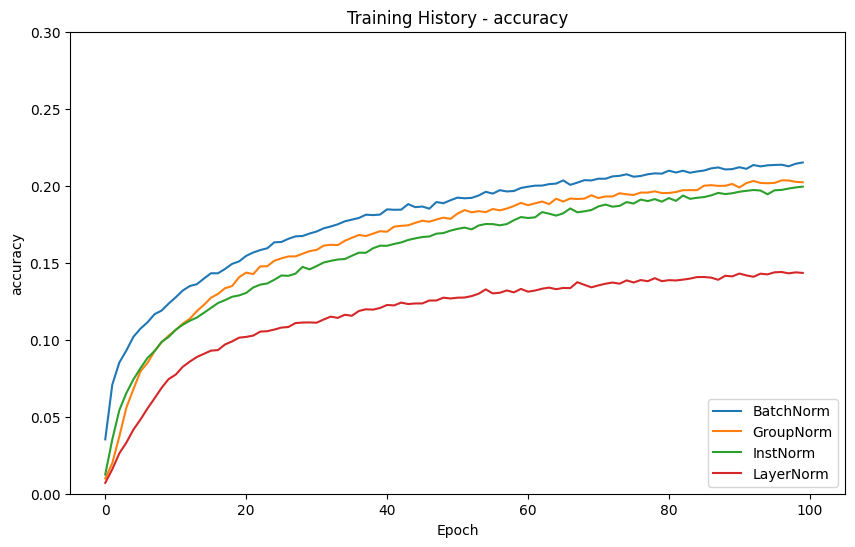

In [20]:
history_files = ['hist1.pkl', 'hist2.pkl', 'hist3.pkl', 'hist4.pkl']
plot_history(history_files, attribute='accuracy', axis=(-5, 105, 0, 0.3), loc='lower right')

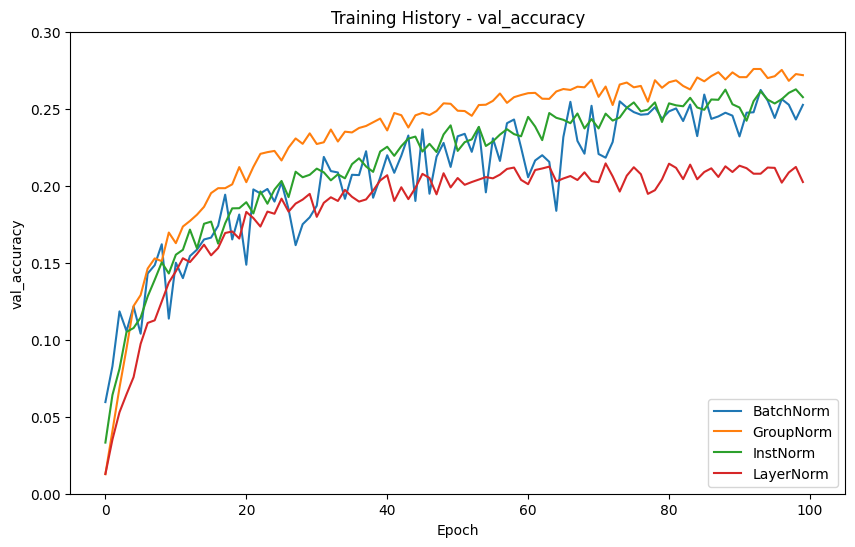

In [21]:
plot_history(history_files, attribute='val_accuracy', axis=(-5, 105, 0, 0.3), loc='lower right')

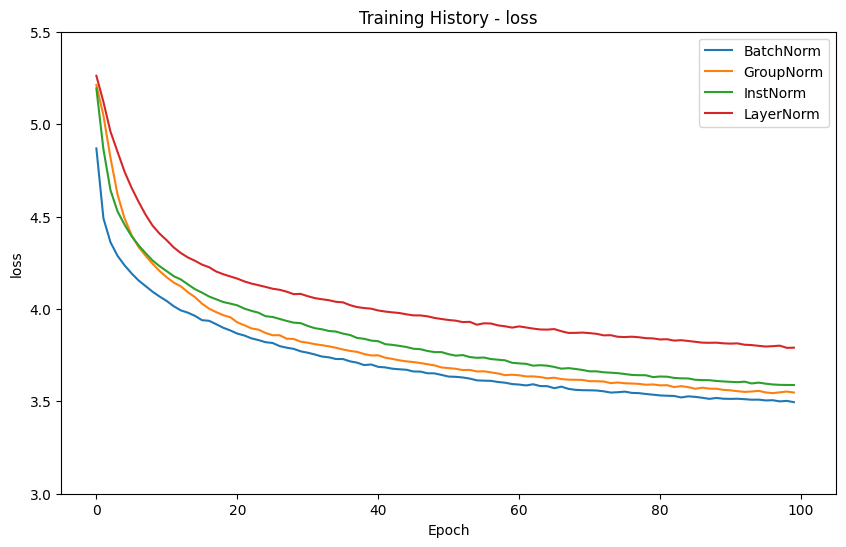

In [22]:
plot_history(history_files, attribute='loss', axis=(-5, 105, 3, 5.5), loc='upper right')

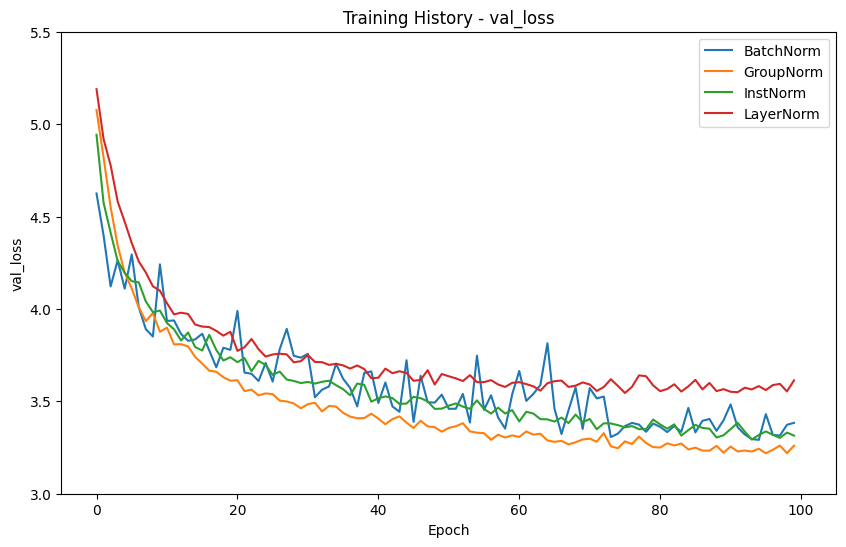

In [23]:
plot_history(history_files, attribute='val_loss', axis=(-5, 105, 3, 5.5), loc='upper right')

In [25]:
import numpy as np
print(np.median(hist1['val_loss'][-5:]))
print(np.median(hist2['val_loss'][-5:]))
print(np.median(hist3['val_loss'][-5:]))
print(np.median(hist4['val_loss'][-5:]))

3.3928637504577637
3.237685203552246
3.3301827907562256
3.5032081604003906


In [ ]:
hist1_loss_valus = 3.3928637504577637
hist2_loss_valus = 3.237685203552246
hist3_loss_valus = 3.3301827907562256
hist4_loss_valus = 3.5032081604003906

## 2:  Sensitivity to batch sizes

### 1: Batch Normalization

In [38]:
model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 29, 29, 64)        9472      
                                                                 
 batch_normalization_10 (Bat  (None, 29, 29, 64)       256       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 15, 15, 256)       16640     
                                                                 
 batch_normalization_11 (Bat  (None, 15, 15, 256)     

In [31]:
batch_size = 2
epochs = 10


BN_2 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.8505 - accuracy: 0.0391 - val_loss: 4.8472 - val_accuracy: 0.0508 - lr: 0.0010
Epoch 2/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.4837 - accuracy: 0.0718 - val_loss: 4.5649 - val_accuracy: 0.0703 - lr: 0.0010
Epoch 3/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.3611 - accuracy: 0.0842 - val_loss: 4.3259 - val_accuracy: 0.0962 - lr: 0.0010
Epoch 4/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.2873 - accuracy: 0.0942 - val_loss: 4.1886 - val_accuracy: 0.1096 - lr: 0.0010
Epoch 5/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.2405 - accuracy: 0.0999 - val_loss: 4.1953 - val_accuracy: 0.1049 - lr: 0.0010
Epoch 6/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.1931 - accuracy: 0.1064 - val_loss: 4.5731 - val_accuracy: 0.0893 - lr: 0.0010
Epoch 7/10
3125/3125 [==============================

In [37]:
batch_size = 4
epochs = 10


BN_4 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.8311 - accuracy: 0.0398 - val_loss: 5.7104 - val_accuracy: 0.0248 - lr: 0.0010
Epoch 2/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.4410 - accuracy: 0.0764 - val_loss: 4.2098 - val_accuracy: 0.1028 - lr: 0.0010
Epoch 3/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.3162 - accuracy: 0.0930 - val_loss: 4.2144 - val_accuracy: 0.1064 - lr: 0.0010
Epoch 4/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.2434 - accuracy: 0.0995 - val_loss: 4.2629 - val_accuracy: 0.1013 - lr: 0.0010
Epoch 5/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.1913 - accuracy: 0.1084 - val_loss: 3.9966 - val_accuracy: 0.1390 - lr: 0.0010
Epoch 6/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.1425 - accuracy: 0.1155 - val_loss: 3.9894 - val_accuracy: 0.1318 - lr: 0.0010
Epoch 7/10
3125/3125 [==============================

In [33]:
batch_size = 8
epochs = 10


BN_8 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/10
3125/3125 [==============================] - 11s 3ms/step - loss: 4.8767 - accuracy: 0.0364 - val_loss: 4.6535 - val_accuracy: 0.0578 - lr: 0.0010
Epoch 2/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.4909 - accuracy: 0.0703 - val_loss: 4.3621 - val_accuracy: 0.0881 - lr: 0.0010
Epoch 3/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.3748 - accuracy: 0.0829 - val_loss: 4.2666 - val_accuracy: 0.1012 - lr: 0.0010
Epoch 4/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.3013 - accuracy: 0.0917 - val_loss: 4.2943 - val_accuracy: 0.0950 - lr: 0.0010
Epoch 5/10
3125/3125 [==============================] - 9s 3ms/step - loss: 4.2446 - accuracy: 0.0979 - val_loss: 4.3228 - val_accuracy: 0.0976 - lr: 0.0010
Epoch 6/10
3125/3125 [==============================] - 9s 3ms/step - loss: 4.1997 - accuracy: 0.1047 - val_loss: 4.2906 - val_accuracy: 0.1095 - lr: 0.0010
Epoch 7/10
3125/3125 [==============================] 

In [35]:
batch_size = 16
epochs = 10


BN_16 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/10
3125/3125 [==============================] - 11s 3ms/step - loss: 4.8853 - accuracy: 0.0359 - val_loss: 4.7072 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 2/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.5095 - accuracy: 0.0685 - val_loss: 4.4676 - val_accuracy: 0.0662 - lr: 0.0010
Epoch 3/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.3841 - accuracy: 0.0822 - val_loss: 4.2371 - val_accuracy: 0.0987 - lr: 0.0010
Epoch 4/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.3030 - accuracy: 0.0934 - val_loss: 4.2067 - val_accuracy: 0.1069 - lr: 0.0010
Epoch 5/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.2414 - accuracy: 0.1005 - val_loss: 4.3379 - val_accuracy: 0.1007 - lr: 0.0010
Epoch 6/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.1949 - accuracy: 0.1056 - val_loss: 4.1788 - val_accuracy: 0.1058 - lr: 0.0010
Epoch 7/10
3125/3125 [==============================

In [39]:
batch_size = 32
epochs = 10


BN_32 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.8627 - accuracy: 0.0372 - val_loss: 4.5846 - val_accuracy: 0.0633 - lr: 0.0010
Epoch 2/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.4804 - accuracy: 0.0699 - val_loss: 4.4242 - val_accuracy: 0.0780 - lr: 0.0010
Epoch 3/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.3579 - accuracy: 0.0846 - val_loss: 4.2691 - val_accuracy: 0.0994 - lr: 0.0010
Epoch 4/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.2883 - accuracy: 0.0948 - val_loss: 4.5462 - val_accuracy: 0.0725 - lr: 0.0010
Epoch 5/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.2343 - accuracy: 0.1013 - val_loss: 4.0554 - val_accuracy: 0.1318 - lr: 0.0010
Epoch 6/10
3125/3125 [==============================] - 10s 3ms/step - loss: 4.1996 - accuracy: 0.1045 - val_loss: 4.1509 - val_accuracy: 0.1278 - lr: 0.0010
Epoch 7/10
3125/3125 [==============================

In [22]:
def plot_history_diff_BS(hists, name, attribute='val_loss', axis=(-1,14,0.7,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acy': 'accuracy'}
    title = {'val_loss': 'Validatiion loss', 'loss': 'Training loss', 'val_accuracy': 'Validatiion accuracy', 'accuracy': 'Training accuracy'}
    num_hists = len(hists)
    
    plt.figure(figsize=(8, 5))  
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(name + title[attribute])  
    plt.ylabel(ylabel[attribute[-3:]])  
    plt.xlabel('epoch')  
    plt.legend(['2', '4', '8','16','32'], loc=loc)  

    plt.show()

In [44]:
hists = [BN_2, BN_4, BN_8, BN_16, BN_32]

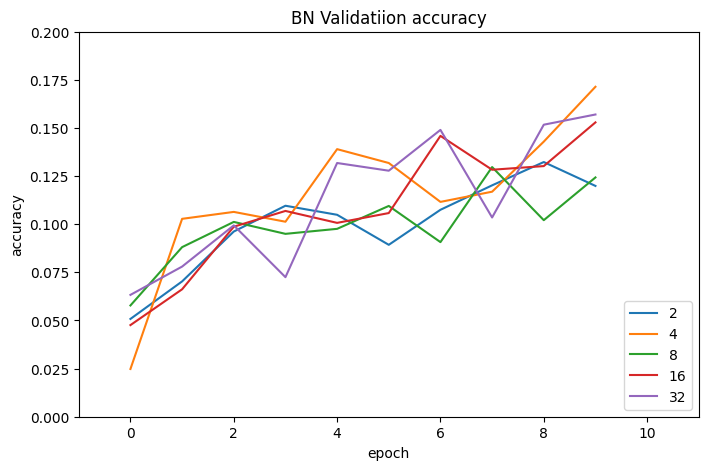

In [51]:
plot_history_diff_BS(hists, name='BN ', attribute='val_accuracy', axis=(-1,11,0,0.2), loc='lower right')

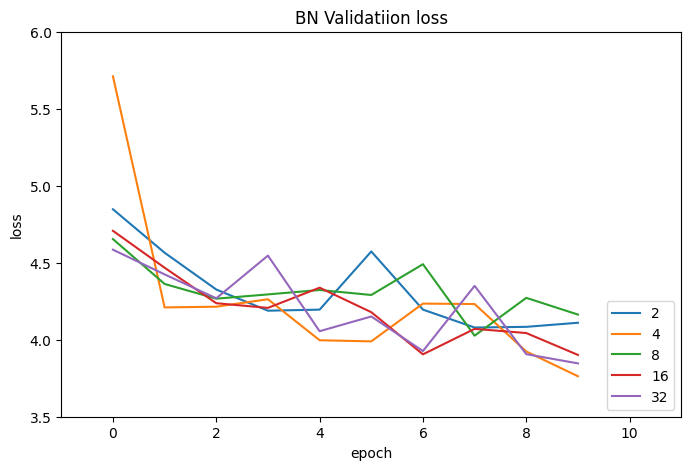

In [55]:
plot_history_diff_BS(hists, name='BN ', attribute='val_loss', axis=(-1,11,3.5,6), loc='lower right')

In [ ]:
BN2_loss_valus = 4.2391349627793469
BN4_loss_valus = 4.1471209534762846
BN8_loss_valus = 4.0623523151246887
BN16_loss_valus = 4.0235621923436256
bN32_loss_valus = 4.1267457452563464

### 2: Group Normalization

In [18]:
model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer=intializer, input_shape=(64, 64, 3)))
model.add(GroupNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer=intializer))
model.add(GroupNormalization())
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        9472      
                                                                 
 group_normalization_10 (Gro  (None, 29, 29, 64)       128       
 upNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 15, 15, 256)       16640     
                                                                 
 group_normalization_11 (Gro  (None, 15, 15, 256)     

In [11]:
batch_size = 2
epochs = 10


GN_2 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/10
3125/3125 [==============================] - 13s 4ms/step - loss: 5.1599 - accuracy: 0.0133 - val_loss: 4.9286 - val_accuracy: 0.0294 - lr: 0.0010
Epoch 2/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.8718 - accuracy: 0.0339 - val_loss: 4.6460 - val_accuracy: 0.0624 - lr: 0.0010
Epoch 3/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.6167 - accuracy: 0.0562 - val_loss: 4.3316 - val_accuracy: 0.0995 - lr: 0.0010
Epoch 4/10
3125/3125 [==============================] - 13s 4ms/step - loss: 4.4552 - accuracy: 0.0708 - val_loss: 4.1796 - val_accuracy: 0.1257 - lr: 0.0010
Epoch 5/10
3125/3125 [==============================] - 13s 4ms/step - loss: 4.3476 - accuracy: 0.0833 - val_loss: 4.0620 - val_accuracy: 0.1329 - lr: 0.0010
Epoch 6/10
3125/3125 [==============================] - 13s 4ms/step - loss: 4.2690 - accuracy: 0.0936 - val_loss: 3.9630 - val_accuracy: 0.1487 - lr: 0.0010
Epoch 7/10
3125/3125 [==============================

In [13]:
batch_size = 4
epochs = 10


GN_4 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/10
3125/3125 [==============================] - 13s 4ms/step - loss: 5.1608 - accuracy: 0.0143 - val_loss: 4.9479 - val_accuracy: 0.0352 - lr: 0.0010
Epoch 2/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.8627 - accuracy: 0.0352 - val_loss: 4.5727 - val_accuracy: 0.0701 - lr: 0.0010
Epoch 3/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.6491 - accuracy: 0.0521 - val_loss: 4.3562 - val_accuracy: 0.0956 - lr: 0.0010
Epoch 4/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.5039 - accuracy: 0.0669 - val_loss: 4.2253 - val_accuracy: 0.1178 - lr: 0.0010
Epoch 5/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.4108 - accuracy: 0.0769 - val_loss: 4.0967 - val_accuracy: 0.1281 - lr: 0.0010
Epoch 6/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.3433 - accuracy: 0.0843 - val_loss: 4.0302 - val_accuracy: 0.1439 - lr: 0.0010
Epoch 7/10
3125/3125 [==============================

In [15]:
batch_size = 8
epochs = 10


GN_8 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/10
3125/3125 [==============================] - 13s 4ms/step - loss: 5.1437 - accuracy: 0.0145 - val_loss: 4.9086 - val_accuracy: 0.0331 - lr: 0.0010
Epoch 2/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.8407 - accuracy: 0.0368 - val_loss: 4.5547 - val_accuracy: 0.0616 - lr: 0.0010
Epoch 3/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.6149 - accuracy: 0.0548 - val_loss: 4.3392 - val_accuracy: 0.0982 - lr: 0.0010
Epoch 4/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.4694 - accuracy: 0.0714 - val_loss: 4.2224 - val_accuracy: 0.1102 - lr: 0.0010
Epoch 5/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.3687 - accuracy: 0.0818 - val_loss: 4.0757 - val_accuracy: 0.1256 - lr: 0.0010
Epoch 6/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.2837 - accuracy: 0.0908 - val_loss: 4.0180 - val_accuracy: 0.1362 - lr: 0.0010
Epoch 7/10
3125/3125 [==============================

In [17]:
batch_size = 16
epochs = 10


GN_16 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/10
3125/3125 [==============================] - 13s 4ms/step - loss: 5.1452 - accuracy: 0.0147 - val_loss: 4.8732 - val_accuracy: 0.0377 - lr: 0.0010
Epoch 2/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.8259 - accuracy: 0.0384 - val_loss: 4.5187 - val_accuracy: 0.0672 - lr: 0.0010
Epoch 3/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.5557 - accuracy: 0.0602 - val_loss: 4.2491 - val_accuracy: 0.1102 - lr: 0.0010
Epoch 4/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.3827 - accuracy: 0.0798 - val_loss: 4.0810 - val_accuracy: 0.1331 - lr: 0.0010
Epoch 5/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.2705 - accuracy: 0.0941 - val_loss: 3.9488 - val_accuracy: 0.1492 - lr: 0.0010
Epoch 6/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.1889 - accuracy: 0.1059 - val_loss: 3.8718 - val_accuracy: 0.1622 - lr: 0.0010
Epoch 7/10
3125/3125 [==============================

In [19]:
batch_size = 32
epochs = 10


GN_32 = model.fit(train_generator,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_generator,
          callbacks = [callback]
          )

Epoch 1/10
3125/3125 [==============================] - 13s 4ms/step - loss: 5.1179 - accuracy: 0.0165 - val_loss: 4.8190 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 2/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.7937 - accuracy: 0.0395 - val_loss: 4.5137 - val_accuracy: 0.0735 - lr: 0.0010
Epoch 3/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.6147 - accuracy: 0.0555 - val_loss: 4.3533 - val_accuracy: 0.1029 - lr: 0.0010
Epoch 4/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.4828 - accuracy: 0.0683 - val_loss: 4.2267 - val_accuracy: 0.1080 - lr: 0.0010
Epoch 5/10
3125/3125 [==============================] - 12s 4ms/step - loss: 4.3840 - accuracy: 0.0789 - val_loss: 4.0697 - val_accuracy: 0.1372 - lr: 0.0010
Epoch 6/10
3125/3125 [==============================] - 11s 4ms/step - loss: 4.3100 - accuracy: 0.0876 - val_loss: 3.9904 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 7/10
3125/3125 [==============================

In [20]:
hists = [GN_2, GN_4, GN_8, GN_16, GN_32]

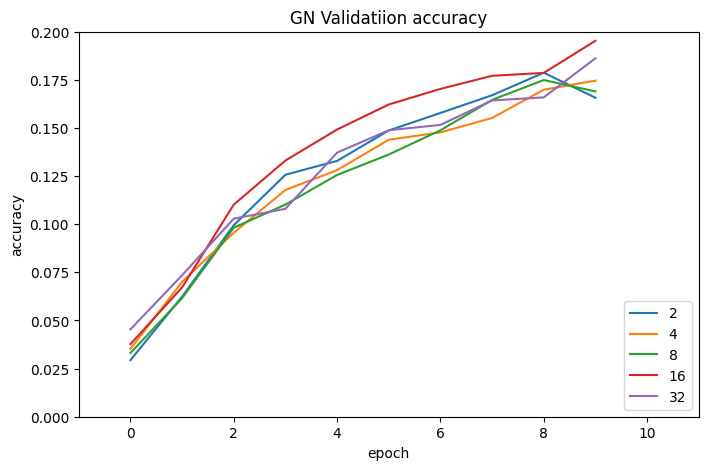

In [25]:
plot_history_diff_BS(hists, name='GN ', attribute='val_accuracy', axis=(-1,11,0,0.2), loc='lower right')

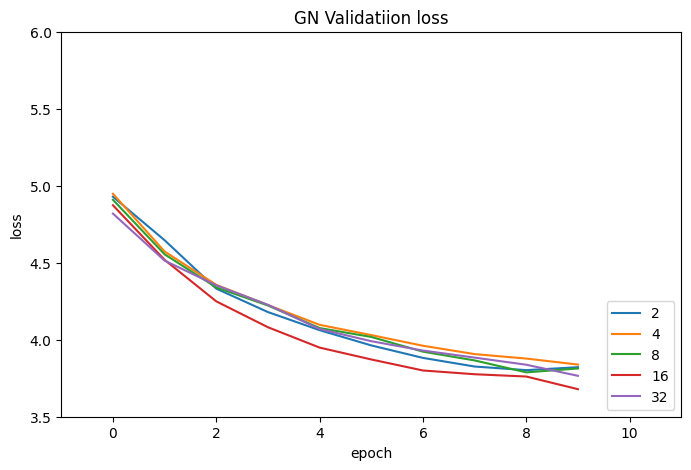

In [26]:
plot_history_diff_BS(hists, name='GN ', attribute='val_loss', axis=(-1,11,3.5,6), loc='lower right')

In [ ]:
GN2_loss_valus = 3.8312234674357450
GN4_loss_valus = 3.9044843468346833
GN8_loss_valus = 3.8677304538630346
GN16_loss_valus = 3.7763358564646890
GN32_loss_valus = 3.8826543466880855